In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# CARGAR LOS DATOS 
print("🔄 CARGANDO DATASET...")
df = pd.read_csv('../data/raw/Worldwide Travel Cities Dataset (Ratings and Climate).csv')
print(f"✅ Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

🔄 CARGANDO DATASET...
✅ Dataset cargado: 560 filas, 19 columnas


In [3]:
# ========================================
# FUNCIÓN AUXILIAR PARA CONVERTIR A NUMÉRICO
# ========================================

def convertir_a_numerico(serie, nombre_columna):
    """
    Convierte una serie a numérica manejando valores mixtos
    """
    try:
        # Intentar conversión directa primero
        serie_numerica = pd.to_numeric(serie, errors='coerce')
        
        # Contar cuántos valores se convirtieron a NaN
        nulos_creados = serie_numerica.isnull().sum() - serie.isnull().sum()
        
        if nulos_creados > 0:
            print(f"   ⚠️ {nombre_columna}: {nulos_creados} valores no numéricos convertidos a NaN")
            
        return serie_numerica
    except Exception as e:
        print(f"   ❌ Error convirtiendo {nombre_columna} a numérico: {e}")
        return serie


In [4]:
# ========================================
# 1. LIMPIEZA ESPECÍFICA PARA DATASET TURÍSTICO
# ========================================

def limpiar_datos_ciudades(df):
    """
    Realiza limpieza específica para el dataset de ciudades turísticas
    """
    print("="*70)
    print("🧹 LIMPIEZA DE DATOS - CIUDADES TURÍSTICAS")
    print("="*70)
    
    df_limpio = df.copy()
    
    print(f"📊 Dataset original: {df_limpio.shape[0]} ciudades, {df_limpio.shape[1]} variables")
    
    # PASO CRÍTICO: Convertir columnas numéricas antes de cualquier operación
    print("\n🔧 CONVERSIÓN DE TIPOS DE DATOS:")
    
    # Identificar columnas que deberían ser numéricas
    columnas_numericas_esperadas = [
        'avg_temp_monthly', 'ideal_durations', 'latitude', 'longitude',
        'culture', 'adventure', 'nature', 'beaches', 'nightlife', 
        'cuisine', 'wellness', 'urban', 'seclusion'
    ]
    
    for col in columnas_numericas_esperadas:
        if col in df_limpio.columns:
            # Verificar si la columna ya es numérica
            if df_limpio[col].dtype in ['object', 'string']:
                print(f"   🔄 Convirtiendo {col} a numérico...")
                df_limpio[col] = convertir_a_numerico(df_limpio[col], col)
            elif df_limpio[col].dtype in ['int64', 'float64']:
                print(f"   ✅ {col} ya es numérico")
            else:
                print(f"   ⚠️ {col} tiene tipo {df_limpio[col].dtype}")
    
    # 1.1 Tratamiento de valores nulos
    print("\n🔧 TRATAMIENTO DE VALORES NULOS:")
    
    nulos_antes = df_limpio.isnull().sum().sum()
    
    for columna in df_limpio.columns:
        nulos_col = df_limpio[columna].isnull().sum()
        
        if nulos_col > 0:
            print(f"   • {columna}: {nulos_col} valores nulos ({nulos_col/len(df_limpio)*100:.1f}%)")
            
            # Estrategias específicas por tipo de variable
            if columna == 'avg_temp_monthly':
                # Temperatura: usar mediana por región si existe
                if 'region' in df_limpio.columns:
                    df_limpio[columna] = df_limpio.groupby('region')[columna].transform(
                        lambda x: x.fillna(x.median())
                    )
                df_limpio[columna].fillna(df_limpio[columna].median(), inplace=True)
                print(f"     → Rellenado con mediana")
                
            elif columna == 'ideal_durations':
                # Duración ideal: usar mediana
                mediana = df_limpio[columna].median()
                df_limpio[columna].fillna(mediana, inplace=True)
                print(f"     → Rellenado con mediana ({mediana:.1f})")
                
            elif columna == 'budget_level':
                # Presupuesto: usar moda
                moda = df_limpio[columna].mode()
                if len(moda) > 0:
                    df_limpio[columna].fillna(moda[0], inplace=True)
                    print(f"     → Rellenado con moda ({moda[0]})")
                
            elif columna in ['culture', 'adventure', 'nature', 'beaches', 'nightlife', 
                           'cuisine', 'wellness', 'urban', 'seclusion']:
                # Ratings de actividades: usar mediana
                if df_limpio[columna].dtype in ['int64', 'float64']:
                    mediana = df_limpio[columna].median()
                    df_limpio[columna].fillna(mediana, inplace=True)
                    print(f"     → Rellenado con mediana ({mediana:.2f})")
                else:
                    print(f"     → ⚠️ No se pudo rellenar {columna} (tipo: {df_limpio[columna].dtype})")
                
            elif columna == 'short_description':
                # Descripción: rellenar con texto genérico
                df_limpio[columna].fillna('Ciudad turística sin descripción', inplace=True)
                print(f"     → Rellenado con texto genérico")
                
            elif df_limpio[columna].dtype in ['int64', 'float64']:
                # Otras variables numéricas: mediana
                mediana = df_limpio[columna].median()
                df_limpio[columna].fillna(mediana, inplace=True)
                print(f"     → Rellenado con mediana ({mediana:.2f})")
                
            else:
                # Variables categóricas: moda
                moda = df_limpio[columna].mode()
                if len(moda) > 0:
                    df_limpio[columna].fillna(moda[0], inplace=True)
                    print(f"     → Rellenado con moda ({moda[0]})")
    
    nulos_despues = df_limpio.isnull().sum().sum()
    print(f"\n✅ Valores nulos eliminados: {nulos_antes} → {nulos_despues}")
    
    # 1.2 Eliminar duplicados
    duplicados_antes = len(df_limpio)
    
    # Duplicados exactos
    df_limpio = df_limpio.drop_duplicates()
    duplicados_exactos = duplicados_antes - len(df_limpio)
    
    # Duplicados por ciudad
    if 'city' in df_limpio.columns:
        ciudades_duplicadas_antes = df_limpio['city'].duplicated().sum()
        if ciudades_duplicadas_antes > 0:
            print(f"\n⚠️ Encontradas {ciudades_duplicadas_antes} ciudades duplicadas:")
            duplicadas = df_limpio[df_limpio['city'].duplicated(keep=False)]['city'].value_counts()
            for ciudad, count in duplicadas.head().items():
                print(f"   • {ciudad}: aparece {count} veces")
            
            # Mantener la primera ocurrencia
            df_limpio = df_limpio.drop_duplicates(subset=['city'], keep='first')
            ciudades_eliminadas = ciudades_duplicadas_antes
            print(f"   → {ciudades_eliminadas} ciudades duplicadas eliminadas")
    
    print(f"\n🗑️ DUPLICADOS ELIMINADOS: {duplicados_exactos} filas exactas")
    
    # 1.3 Validar rangos de datos (SOLO PARA COLUMNAS NUMÉRICAS CONFIRMADAS)
    print(f"\n✅ VALIDACIÓN DE RANGOS:")
    
    # Validar ratings de actividades
    rating_columns = ['culture', 'adventure', 'nature', 'beaches', 'nightlife', 
                     'cuisine', 'wellness', 'urban', 'seclusion']
    
    for col in rating_columns:
        if col in df_limpio.columns and df_limpio[col].dtype in ['int64', 'float64']:
            # Verificar rango actual
            min_val = df_limpio[col].min()
            max_val = df_limpio[col].max()
            
            # Si los valores están en rango 0-1, los escalamos a 0-10
            if max_val <= 1 and min_val >= 0:
                df_limpio[col] = df_limpio[col] * 10
                print(f"   • {col}: Escalado de [0-1] a [0-10]")
            # Si están fuera del rango esperado, los clippeamos
            elif min_val < 0 or max_val > 10:
                valores_fuera_rango = len(df_limpio[(df_limpio[col] < 0) | (df_limpio[col] > 10)])
                df_limpio[col] = np.clip(df_limpio[col], 0, 10)
                print(f"   • {col}: {valores_fuera_rango} valores ajustados al rango [0-10]")
            else:
                print(f"   • {col}: ✅ rango válido [0-10]")
        elif col in df_limpio.columns:
            print(f"   • {col}: ⚠️ No es numérico, saltando validación")
    
    # Validar coordenadas (solo si son numéricas)
    if 'latitude' in df_limpio.columns and df_limpio['latitude'].dtype in ['int64', 'float64']:
        lat_fuera = len(df_limpio[(df_limpio['latitude'] < -90) | (df_limpio['latitude'] > 90)])
        if lat_fuera > 0:
            df_limpio['latitude'] = np.clip(df_limpio['latitude'], -90, 90)
            print(f"   • latitude: {lat_fuera} valores ajustados al rango [-90, 90]")
        else:
            print(f"   • latitude: ✅ rango válido")
    
    if 'longitude' in df_limpio.columns and df_limpio['longitude'].dtype in ['int64', 'float64']:
        lon_fuera = len(df_limpio[(df_limpio['longitude'] < -180) | (df_limpio['longitude'] > 180)])
        if lon_fuera > 0:
            df_limpio['longitude'] = np.clip(df_limpio['longitude'], -180, 180)
            print(f"   • longitude: {lon_fuera} valores ajustados al rango [-180, 180]")
        else:
            print(f"   • longitude: ✅ rango válido")
    
    # Validar duración ideal (solo si es numérica)
    if 'ideal_durations' in df_limpio.columns and df_limpio['ideal_durations'].dtype in ['int64', 'float64']:
        duracion_extrema = len(df_limpio[(df_limpio['ideal_durations'] < 1) | 
                                        (df_limpio['ideal_durations'] > 30)])
        if duracion_extrema > 0:
            df_limpio['ideal_durations'] = np.clip(df_limpio['ideal_durations'], 1, 30)
            print(f"   • ideal_durations: {duracion_extrema} valores ajustados al rango [1-30 días]")
        else:
            print(f"   • ideal_durations: ✅ rango válido")
    
    print(f"\n📊 Dataset limpio: {df_limpio.shape[0]} ciudades, {df_limpio.shape[1]} variables")
    return df_limpio


In [5]:
# ========================================
# 2. DETECCIÓN AVANZADA DE OUTLIERS
# ========================================

def detectar_outliers_turismo(df):
    """
    Detecta outliers específicos para datos turísticos
    """
    print("="*70)
    print("🎯 DETECCIÓN DE OUTLIERS - ANÁLISIS TURÍSTICO")
    print("="*70)
    
    outliers_info = {}
    # SOLO seleccionar columnas que son efectivamente numéricas
    columnas_numericas = df.select_dtypes(include=[np.number]).columns
    
    if len(columnas_numericas) == 0:
        print("⚠️ No se encontraron columnas numéricas para análisis de outliers")
        return outliers_info
    
    print(f"📊 Analizando {len(columnas_numericas)} columnas numéricas: {list(columnas_numericas)}")
    
    # Crear visualización de outliers
    n_cols = 3
    n_rows = int(np.ceil(len(columnas_numericas) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    fig.suptitle('🎯 Detección de Outliers por Variable', fontsize=16, fontweight='bold')
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(columnas_numericas):
        row = i // n_cols
        col_idx = i % n_cols
        
        ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
        
        # Verificar que la columna tenga datos válidos
        datos_validos = df[col].dropna()
        
        if len(datos_validos) == 0:
            ax.text(0.5, 0.5, f'{col}\nSin datos válidos', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])
            continue
        
        # Boxplot para visualizar outliers
        try:
            bp = ax.boxplot(datos_validos, patch_artist=True)
            bp['boxes'][0].set_facecolor('lightblue')
            bp['boxes'][0].set_alpha(0.7)
            
            # Calcular estadísticas de outliers
            Q1 = datos_validos.quantile(0.25)
            Q3 = datos_validos.quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR
            
            outliers_iqr = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]
            
            # Z-Score method (solo si tenemos datos suficientes)
            outliers_zscore = 0
            if len(datos_validos) > 3:
                try:
                    z_scores = np.abs(stats.zscore(datos_validos))
                    outliers_zscore = len(z_scores[z_scores > 2])
                except:
                    outliers_zscore = 0
            
            # Guardar información
            outliers_info[col] = {
                'iqr_count': len(outliers_iqr),
                'iqr_percentage': (len(outliers_iqr) / len(df)) * 100,
                'zscore_count': outliers_zscore,
                'limite_inf': limite_inferior,
                'limite_sup': limite_superior,
                'outliers_values': outliers_iqr[col].tolist() if len(outliers_iqr) < 10 else []
            }
            
            ax.set_title(f'{col}\nOutliers: {len(outliers_iqr)} ({(len(outliers_iqr)/len(df)*100):.1f}%)')
            
        except Exception as e:
            print(f"   ⚠️ Error procesando {col}: {e}")
            ax.text(0.5, 0.5, f'{col}\nError en análisis', 
                   ha='center', va='center', transform=ax.transAxes)
        
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
    
    # Ocultar subplots vacíos
    for i in range(len(columnas_numericas), n_rows * n_cols):
        row = i // n_cols
        col_idx = i % n_cols
        ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Reportar outliers específicos para turismo
    print("\n📊 RESUMEN DE OUTLIERS POR VARIABLE:")
    for col, info in outliers_info.items():
        print(f"\n   🔍 {col}:")
        print(f"      • IQR Method: {info['iqr_count']} outliers ({info['iqr_percentage']:.1f}%)")
        print(f"      • Z-Score Method: {info['zscore_count']} outliers")
        print(f"      • Rango normal: [{info['limite_inf']:.2f}, {info['limite_sup']:.2f}]")
        
        if info['outliers_values']:
            print(f"      • Valores outliers: {[round(x, 2) for x in info['outliers_values'][:5]]}...")
    
    # Análisis especial para ciudades extremas
    if 'city' in df.columns:
        print(f"\n🌟 ANÁLISIS DE CIUDADES EXTREMAS:")
        
        # Analizar ratings de actividades
        activity_columns = ['culture', 'adventure', 'nature', 'beaches', 'nightlife', 
                           'cuisine', 'wellness', 'urban', 'seclusion']
        existing_activities = [col for col in activity_columns if col in df.columns and 
                              df[col].dtype in ['int64', 'float64']]
        
        if existing_activities:
            # Calcular promedio de actividades por ciudad
            df_temp = df.copy()
            df_temp['avg_activity_rating'] = df_temp[existing_activities].mean(axis=1)
            
            # Ciudades con mejor puntuación general
            high_rating_threshold = df_temp['avg_activity_rating'].quantile(0.90)
            ciudades_top = df_temp[df_temp['avg_activity_rating'] >= high_rating_threshold].nlargest(5, 'avg_activity_rating')
            
            print(f"   📈 Top ciudades por rating promedio (>= {high_rating_threshold:.1f}):")
            for _, city in ciudades_top.iterrows():
                print(f"      • {city['city']}: {city['avg_activity_rating']:.1f}/10")
            
            # Ciudades con menor puntuación
            low_rating_threshold = df_temp['avg_activity_rating'].quantile(0.10)
            ciudades_bottom = df_temp[df_temp['avg_activity_rating'] <= low_rating_threshold].nsmallest(5, 'avg_activity_rating')
            
            print(f"   📉 Ciudades con rating bajo (<= {low_rating_threshold:.1f}):")
            for _, city in ciudades_bottom.iterrows():
                print(f"      • {city['city']}: {city['avg_activity_rating']:.1f}/10")
    
    return outliers_info


In [6]:
# ========================================
# 3. CREACIÓN DE NUEVAS VARIABLES
# ========================================

def crear_variables_derivadas_turismo(df):
    """
    Crea nuevas variables específicas para análisis turístico
    """
    print("="*70)
    print("🔄 CREACIÓN DE VARIABLES DERIVADAS")
    print("="*70)
    
    df_transformado = df.copy()
    variables_creadas = 0
    
    # 3.1 Rating promedio de actividades (solo columnas numéricas)
    activity_columns = ['culture', 'adventure', 'nature', 'beaches', 'nightlife', 
                       'cuisine', 'wellness', 'urban', 'seclusion']
    existing_activities = [col for col in activity_columns if col in df_transformado.columns and 
                          df_transformado[col].dtype in ['int64', 'float64']]
    
    if len(existing_activities) >= 3:
        df_transformado['avg_activity_rating'] = df_transformado[existing_activities].mean(axis=1)
        variables_creadas += 1
        print(f"   ✅ 'avg_activity_rating' creada (promedio de {len(existing_activities)} actividades)")
    
    # 3.2 Categorías de rating general
    if 'avg_activity_rating' in df_transformado.columns:
        df_transformado['rating_category'] = pd.cut(
            df_transformado['avg_activity_rating'],
            bins=[0, 4, 6, 7.5, 10],
            labels=['Bajo', 'Medio', 'Alto', 'Excelente'],
            include_lowest=True
        )
        variables_creadas += 1
        print("   ✅ 'rating_category' creada (Bajo/Medio/Alto/Excelente)")
    
    # 3.3 Categorías de temperatura
    if ('avg_temp_monthly' in df_transformado.columns and 
        df_transformado['avg_temp_monthly'].dtype in ['int64', 'float64']):
        df_transformado['temp_category'] = pd.cut(
            df_transformado['avg_temp_monthly'],
            bins=[-50, 10, 20, 28, 50],
            labels=['Frío', 'Templado', 'Cálido', 'Caluroso'],
            include_lowest=True
        )
        variables_creadas += 1
        print("   ✅ 'temp_category' creada (Frío/Templado/Cálido/Caluroso)")
    
    # 3.4 Índices combinados (solo si las columnas son numéricas)
    if ('adventure' in df_transformado.columns and 'nature' in df_transformado.columns and
        df_transformado['adventure'].dtype in ['int64', 'float64'] and
        df_transformado['nature'].dtype in ['int64', 'float64']):
        df_transformado['adventure_nature_index'] = (df_transformado['adventure'] + 
                                                   df_transformado['nature']) / 2
        variables_creadas += 1
        print("   ✅ 'adventure_nature_index' creada (índice aventura + naturaleza)")
    
    if ('culture' in df_transformado.columns and 'cuisine' in df_transformado.columns and
        df_transformado['culture'].dtype in ['int64', 'float64'] and
        df_transformado['cuisine'].dtype in ['int64', 'float64']):
        df_transformado['culture_food_index'] = (df_transformado['culture'] + 
                                               df_transformado['cuisine']) / 2
        variables_creadas += 1
        print("   ✅ 'culture_food_index' creada (índice cultura + gastronomía)")
    
    if ('nightlife' in df_transformado.columns and 'urban' in df_transformado.columns and
        df_transformado['nightlife'].dtype in ['int64', 'float64'] and
        df_transformado['urban'].dtype in ['int64', 'float64']):
        df_transformado['nightlife_urban_index'] = (df_transformado['nightlife'] + 
                                                  df_transformado['urban']) / 2
        variables_creadas += 1
        print("   ✅ 'nightlife_urban_index' creada (índice vida nocturna + urbano)")
    
    # 3.5 Categoría de duración ideal
    if ('ideal_durations' in df_transformado.columns and 
        df_transformado['ideal_durations'].dtype in ['int64', 'float64']):
        df_transformado['duration_category'] = pd.cut(
            df_transformado['ideal_durations'],
            bins=[0, 3, 7, 14, 30],
            labels=['Corta (1-3 días)', 'Media (4-7 días)', 'Larga (8-14 días)', 'Extendida (15+ días)'],
            include_lowest=True
        )
        variables_creadas += 1
        print("   ✅ 'duration_category' creada (categorías de duración)")
    
    # 3.6 Índice de relajación
    if (all(col in df_transformado.columns for col in ['wellness', 'seclusion', 'urban']) and
        all(df_transformado[col].dtype in ['int64', 'float64'] for col in ['wellness', 'seclusion', 'urban'])):
        df_transformado['relaxation_index'] = ((df_transformado['wellness'] + 
                                              df_transformado['seclusion'] - 
                                              df_transformado['urban']) / 3).clip(0, 10)
        variables_creadas += 1
        print("   ✅ 'relaxation_index' creada (índice de relajación)")
    
    # 3.7 Tipo de destino predominante
    if len(existing_activities) >= 5:
        # Encontrar la actividad con mayor puntuación para cada ciudad
        df_transformado['main_attraction_type'] = df_transformado[existing_activities].idxmax(axis=1)
        variables_creadas += 1
        print("   ✅ 'main_attraction_type' creada (tipo principal de atracción)")
    
    # 3.8 Coordenadas hemisferio
    if ('latitude' in df_transformado.columns and 
        df_transformado['latitude'].dtype in ['int64', 'float64']):
        df_transformado['hemisphere'] = df_transformado['latitude'].apply(
            lambda x: 'Norte' if x >= 0 else 'Sur'
        )
        variables_creadas += 1
        print("   ✅ 'hemisphere' creada (hemisferio norte/sur)")
    
    print(f"\n📊 RESUMEN DE TRANSFORMACIÓN:")
    print(f"   • Variables originales: {len(df.columns)}")
    print(f"   • Variables nuevas creadas: {variables_creadas}")
    print(f"   • Variables totales: {len(df_transformado.columns)}")
    
    return df_transformado


In [7]:
# ========================================
# 4. FUNCIÓN PRINCIPAL FASE 2
# ========================================

def main_fase2_ciudades(df):
    """
    Ejecuta toda la fase 2 de limpieza para dataset turístico
    """
    print("🚀 INICIANDO EDA - FASE 2: LIMPIEZA Y PREPROCESAMIENTO")
    print("Dataset: Worldwide Travel Cities Ratings and Climate")
    print("="*70)
    
    # Guardar copia original para comparación
    df_original = df.copy()
    
    # 1. Limpiar datos
    print("🔧 PASO 1: LIMPIEZA DE DATOS")
    df_limpio = limpiar_datos_ciudades(df)
    
    # 2. Detectar outliers
    print("\n🎯 PASO 2: DETECCIÓN DE OUTLIERS")
    outliers_info = detectar_outliers_turismo(df_limpio)
    
    # 3. Crear variables derivadas
    print("\n🔄 PASO 3: CREACIÓN DE VARIABLES DERIVADAS")
    df_final = crear_variables_derivadas_turismo(df_limpio)
    
    # 4. Resumen final
    print("\n" + "="*70)
    print("✅ FASE 2 COMPLETADA EXITOSAMENTE")
    print(f"📊 Dataset procesado: {df_final.shape[0]} ciudades, {df_final.shape[1]} variables")
    
    # Mostrar cambios realizados
    print(f"\n📈 CAMBIOS REALIZADOS:")
    print(f"   • Filas: {len(df_original)} → {len(df_final)}")
    print(f"   • Columnas: {len(df_original.columns)} → {len(df_final.columns)}")
    print(f"   • Valores nulos eliminados: {df_original.isnull().sum().sum()} → {df_final.isnull().sum().sum()}")
    
    # Mostrar nuevas variables creadas
    nuevas_variables = [col for col in df_final.columns if col not in df_original.columns]
    print(f"   • Nuevas variables: {nuevas_variables}")
    
    print("\n📝 Próximo paso: Análisis exploratorio detallado")
    
    return df_final, outliers_info

🚀 EJECUTANDO FASE 2 COMPLETA...

📊 INFORMACIÓN INICIAL:
Shape: (560, 19)
Columnas: ['id', 'city', 'country', 'region', 'short_description', 'latitude', 'longitude', 'avg_temp_monthly', 'ideal_durations', 'budget_level', 'culture', 'adventure', 'nature', 'beaches', 'nightlife', 'cuisine', 'wellness', 'urban', 'seclusion']

Primeras 3 filas:
                                     id            city country  \
0  c54acf38-3029-496b-8c7a-8343ad82785c           Milan   Italy   
1  0bd12654-ed64-424e-a044-7bc574bcf078  Yasawa Islands    Fiji   
2  73036cda-9134-46fc-a2c6-807782d59dfb        Whistler  Canada   

          region                                  short_description  \
0         europe  Chic streets lined with fashion boutiques, his...   
1        oceania  Crystal-clear waters, secluded beaches, and vi...   
2  north_america  Snow-capped peaks and lush forests create a se...   

    latitude   longitude                                   avg_temp_monthly  \
0  45.464194    9.189635 

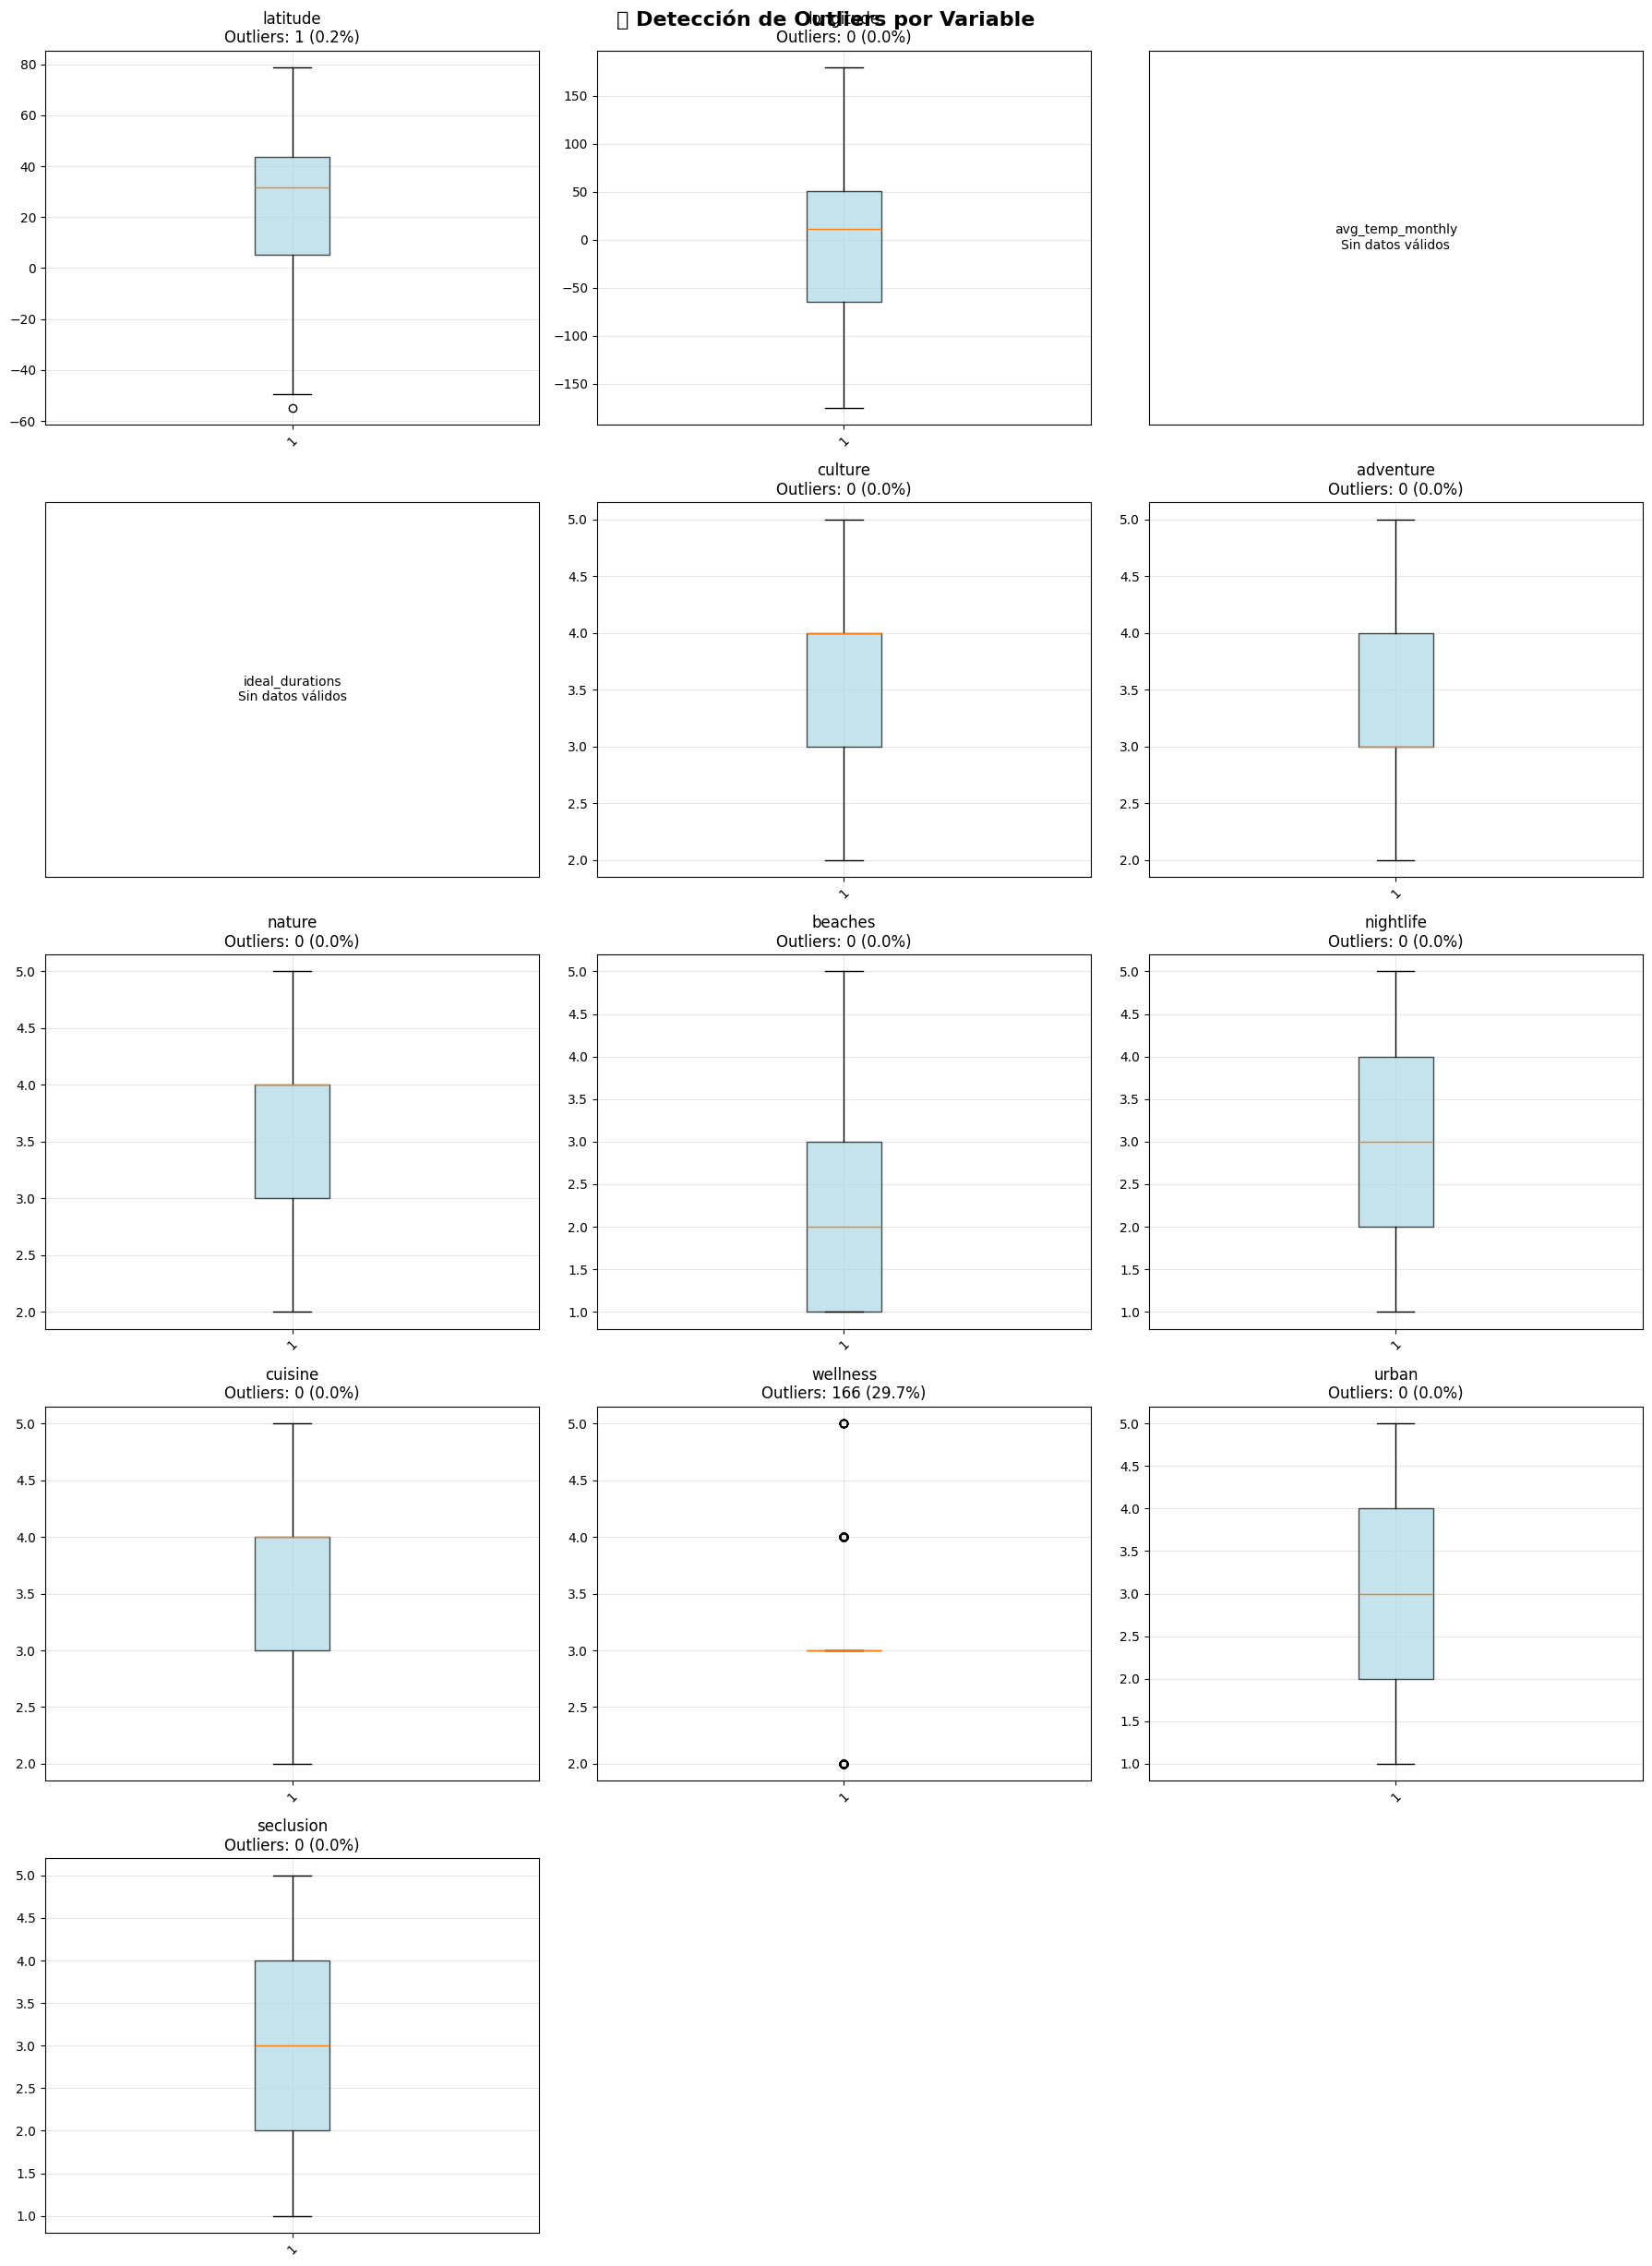


📊 RESUMEN DE OUTLIERS POR VARIABLE:

   🔍 latitude:
      • IQR Method: 1 outliers (0.2%)
      • Z-Score Method: 26 outliers
      • Rango normal: [-52.64, 101.50]
      • Valores outliers: [-54.81]...

   🔍 longitude:
      • IQR Method: 0 outliers (0.0%)
      • Z-Score Method: 29 outliers
      • Rango normal: [-236.63, 222.31]

   🔍 culture:
      • IQR Method: 0 outliers (0.0%)
      • Z-Score Method: 20 outliers
      • Rango normal: [1.50, 5.50]

   🔍 adventure:
      • IQR Method: 0 outliers (0.0%)
      • Z-Score Method: 31 outliers
      • Rango normal: [1.50, 5.50]

   🔍 nature:
      • IQR Method: 0 outliers (0.0%)
      • Z-Score Method: 0 outliers
      • Rango normal: [1.50, 5.50]

   🔍 beaches:
      • IQR Method: 0 outliers (0.0%)
      • Z-Score Method: 0 outliers
      • Rango normal: [-2.00, 6.00]

   🔍 nightlife:
      • IQR Method: 0 outliers (0.0%)
      • Z-Score Method: 56 outliers
      • Rango normal: [-1.00, 7.00]

   🔍 cuisine:
      • IQR Method: 0 outli

In [8]:
# ========================================
# 🚀 EJECUTAR EL ANÁLISIS COMPLETO
# ========================================

print("🚀 EJECUTANDO FASE 2 COMPLETA...")

# Mostrar información inicial
print(f"\n📊 INFORMACIÓN INICIAL:")
print(f"Shape: {df.shape}")
print(f"Columnas: {list(df.columns)}")
print("\nPrimeras 3 filas:")
print(df.head(3))

# Ejecutar análisis completo
df_final, outliers_info = main_fase2_ciudades(df)

# Mostrar información final del dataset
print("\n" + "="*70)
print("📊 INFORMACIÓN FINAL DEL DATASET:")
print("="*70)
print(f"Shape: {df_final.shape}")
print(f"Columnas: {list(df_final.columns)}")
print("\nPrimeras 3 filas del dataset procesado:")
print(df_final.head(3))

# Estadísticas descriptivas de las nuevas variables
nuevas_vars_numericas = ['avg_activity_rating', 'adventure_nature_index', 'culture_food_index', 
                        'nightlife_urban_index', 'relaxation_index']
existing_new_vars = [var for var in nuevas_vars_numericas if var in df_final.columns]

if existing_new_vars:
    print(f"\n📈 ESTADÍSTICAS DE NUEVAS VARIABLES:")
    print(df_final[existing_new_vars].describe())

print("\n🎉 ¡FASE 2 COMPLETADA EXITOSAMENTE!")
print("Ahora tienes el dataset limpio y con nuevas variables para el análisis.")